In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #uses PIL if available. 

from data_loader import get_loader, FlickrDataset, Vocabulary

In [2]:
resources = '../resources/flickr8k/'
images_path = resources + 'Images/'
captions_path = resources + 'captions.txt'

In [3]:
caps = pd.read_csv(captions_path)
caps.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


Shape: (500, 375, 3)


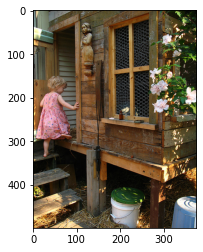

0 A child in a pink dress is climbing up a set of stairs in an entry way .
1 A girl going into a wooden building .
2 A little girl climbing into a wooden playhouse .
3 A little girl climbing the stairs to her playhouse .
4 A little girl in a pink dress going into a wooden cabin .


In [4]:
image = caps['image'].iloc[0]
captions = caps.loc[caps['image']==image, 'caption']

img=mpimg.imread(images_path+image)
print('Shape:', np.shape(img.tolist()))
plt.imshow(img)
plt.show()

for i,c in enumerate(captions):
    print(i,c)

### Test Vocabulary

In [5]:
vocab = Vocabulary(unk_cutoff=0)
vocab.fit(["i don't like dogs","i don't like cats"])
vocab.word_to_idx

{'<PAD>': 0,
 '<START>': 1,
 '<END>': 2,
 '<UNK>': 3,
 'cats': 4,
 'do': 5,
 'dogs': 6,
 'i': 7,
 'like': 8,
 "n't": 9}

In [6]:
vocab.numericalize_sentence('i like dogs', add_start_end=True)

[1, 7, 8, 6, 2]

### FlickrDataset

In [7]:
import torchvision.transforms as transforms

In [8]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
#defing the transform to be applied
transf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = FlickrDataset(
    images_dir=images_path,
    captions_path=captions_path,
    transform=transf,
    unk_cutoff=1
)


Shape: (3, 224, 224)


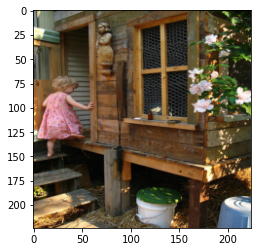

Tokens: tensor([   1,   68, 1407, 3745,   68, 5388, 2290, 3836, 1511, 7983,   68, 6404,
        4894, 7066, 3745,  245, 2511, 8213,   15,    2])
Sentence:
['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>']


In [10]:

img, caps = dataset[0]
print('Shape:', np.shape(img.tolist()))
show_image(img)
print("Tokens:",caps)
print("Sentence:")
print([dataset.vocab.idx_to_word[token] for token in caps.tolist()])

### get_loader

In [11]:
batch_size = 4
num_workers = 1

data_loader = get_loader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    batch_first=True,
    shuffle=True
)


captions shape: torch.Size([4, 13])

['<START>', 'three', 'kids', 'lean', 'into', 'the', 'water', 'edge', 'wearing', 'bright', 'pants', '.', '<END>']


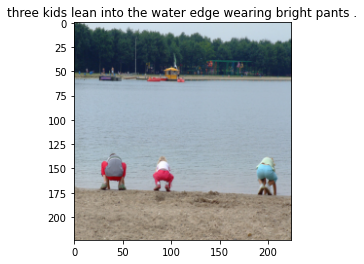

['<START>', 'man', 'dressed', 'in', 'white', 'playing', 'sports', '.', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


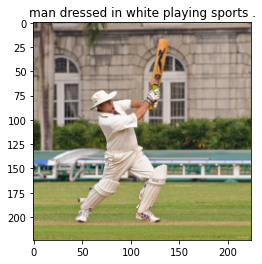

['<START>', 'the', 'two', 'people', 'are', 'viewing', 'an', 'artist', "'s", 'piece', '.', '<END>', '<PAD>']


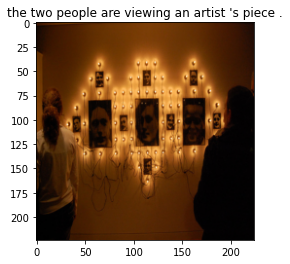

['<START>', 'a', 'skater', 'goes', 'through', 'a', 'course', '.', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


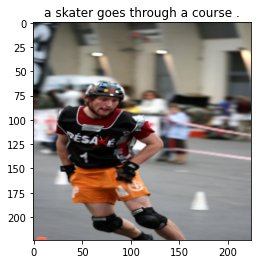

In [12]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

end = dataset.end_label
print('captions shape:', np.shape(captions))
print()
#showing info of image in single batch
for i in range(batch_size):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.idx_to_word[token] for token in cap.tolist()]
    print(caption_label)
    eos_index = caption_label.index(end)
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

In [13]:
print(captions)

tensor([[   1, 7605, 3988, 4134, 3818, 7567, 8179, 2398, 8219,  985, 5115,   15,
            2],
        [   1, 4371, 2291, 3745, 8290, 5452, 6989,   15,    2,    0,    0,    0,
            0],
        [   1, 7567, 7912, 5272,  328, 8081,  245,  362,    9, 5352,   15,    2,
            0],
        [   1,   68, 6638, 3204, 7610,   68, 1792,   15,    2,    0,    0,    0,
            0]])


### Train - Validation

In [14]:
import torch

In [15]:
test_size = 0.1
L = len(dataset)

test_size = int(test_size*L)
train_size = L - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataset

In [16]:
batch_size = 4
num_workers = 1

train_loader = get_loader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    batch_first=True,
    shuffle=True
)

print('Len all:', len(data_loader))
print('Len training:', len(train_loader))


Len all: 10114
Len training: 9103


In [18]:
from tqdm.auto import tqdm
import time
for i in tqdm(range(100)):
    time.sleep(0.1)

  0%|          | 0/100 [00:00<?, ?it/s]

99